In [1]:
# creating the path for module errors
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent  # go up one level
sys.path.append(str(PROJECT_ROOT))

In [ ]:
# Import from your project modules
from rpis.ingestion import load_race_session
from rpis.processing import clean_laps, segment_stints
from rpis.modelling import (
    fit_degradation_model,
    predict_lap_time,
    simulate_stint,
    simulate_strategy,
    build_compound_models,
    ensure_compound_models,
    compare_strategies
)

# Load a race session
session = load_race_session(2023, "Bahrain", "R")

# Clean laps and segment stints
laps = clean_laps(session.laps)
segmented = segment_stints(laps)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']


In [14]:
import matplotlib.pyplot as plt

In [12]:
models = build_compound_models(segmented)
models = ensure_compound_models(models)

print("Available tyre models:", models.keys())

Available tyre models: dict_keys(['SOFT', 'HARD', 'MEDIUM'])


In [13]:
soft_laps = segmented[segmented['Compound'] == 'SOFT']
model, b, a = fit_degradation_model(soft_laps)
print(f"SOFT degradation per lap: {b:.3f} sec/lap")

SOFT degradation per lap: -0.068 sec/lap


### Fit degradation models for one driver

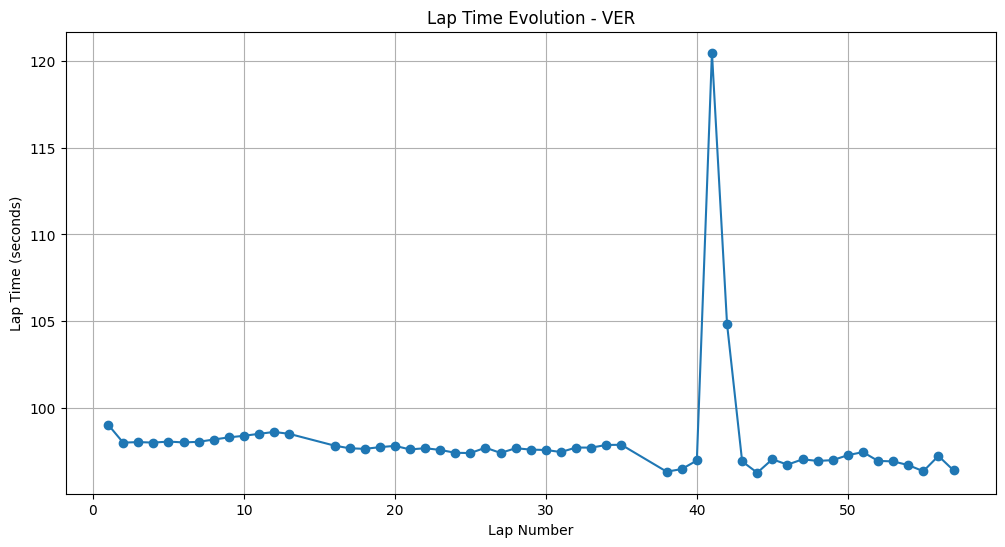

In [15]:
driver = "VER"
driver_laps = segmented[segmented['Driver'] == driver]

plt.figure(figsize=(12,6))
plt.plot(driver_laps['LapNumber'], driver_laps['LapTime'].dt.total_seconds(), marker='o')
plt.title(f"Lap Time Evolution - {driver}")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (seconds)")
plt.grid(True)
plt.show()

In [16]:
soft_model = models['SOFT']
total_soft_stint = simulate_stint(soft_model, 15)
print(f"Estimated 15-lap SOFT stint time: {total_soft_stint:.1f} sec")

Estimated 15-lap SOFT stint time: 1492.5 sec


In [17]:
strategies = {
    "1-stop: S-H": [
        ("SOFT", 15),
        ("HARD", 35)
    ],
    "2-stop: S-M-H": [
        ("SOFT", 10),
        ("MEDIUM", 20),
        ("HARD", 20)
    ]
}

comparison = compare_strategies(strategies, models, pit_loss=22)
comparison

,Strategy,TotalTimeSec,DeltaToBest
0,1-stop: S-H,4975.609520,0.000000
1,2-stop: S-M-H,4999.847906,24.238386
